# Contact
For any doubt, question, issue or help, you can always contact us at the following email addresses:

Teaching Assistants:

- Federico Ruggeri -> federico.ruggeri6@unibo.it
- Eleonora Mancini -> e.mancini@unibo.it

Professor:
- Paolo Torroni -> p.torroni@unibo.it

# Introduction
You are asked to address the [EXIST 2023 Task 1](https://clef2023.clef-initiative.eu/index.php?page=Pages/labs.html#EXIST) on sexism detection.

## Problem Definition
The systems have to decide whether or not a given tweet contains or describes sexist expressions or behaviors (i.e., it is sexist itself, describes a sexist situation or criticizes a sexist behavior).

### Examples:

**Text**: *Can’t go a day without women womening*

**Label**: Sexist

**Text**: *''Society's set norms! Happy men's day though!#weareequal''*

**Label**: Not sexist

#[Task 1 - 1.0 points] Corpus

We have preparared a small version of EXIST dataset in our dedicated [Github repository](https://github.com/lt-nlp-lab-unibo/nlp-course-material/tree/main/2024-2025/Assignment%201/data).

Check the `A1/data` folder. It contains 3 `.json` files representing `training`, `validation` and `test` sets.

The three sets are slightly unbalanced, with a bias toward the `Non-sexist` class.



### Dataset Description
- The dataset contains tweets in both English and Spanish.
- There are labels for multiple tasks, but we are focusing on **Task 1**.
- For Task 1, soft labels are assigned by six annotators.
- The labels for Task 1 represent whether the tweet is sexist ("YES") or not ("NO").







### Example


    "203260": {
        "id_EXIST": "203260",
        "lang": "en",
        "tweet": "ik when mandy says “you look like a whore” i look cute as FUCK",
        "number_annotators": 6,
        "annotators": ["Annotator_473", "Annotator_474", "Annotator_475", "Annotator_476", "Annotator_477", "Annotator_27"],
        "gender_annotators": ["F", "F", "M", "M", "M", "F"],
        "age_annotators": ["18-22", "23-45", "18-22", "23-45", "46+", "46+"],
        "labels_task1": ["YES", "YES", "YES", "NO", "YES", "YES"],
        "labels_task2": ["DIRECT", "DIRECT", "REPORTED", "-", "JUDGEMENTAL", "REPORTED"],
        "labels_task3": [
          ["STEREOTYPING-DOMINANCE"],
          ["OBJECTIFICATION"],
          ["SEXUAL-VIOLENCE"],
          ["-"],
          ["STEREOTYPING-DOMINANCE", "OBJECTIFICATION"],
          ["OBJECTIFICATION"]
        ],
        "split": "TRAIN_EN"
      }
    }


### Instructions
1. **Download** the `A1/data` folder.
2. **Load** the three JSON files and encode them as pandas dataframes.
3. **Generate hard labels** for Task 1 using majority voting and store them in a new dataframe column called `hard_label_task1`. Items without a clear majority will be removed from the dataset.
4. **Filter the DataFrame** to keep only rows where the `lang` column is `'en'`.
5. **Remove unwanted columns**: Keep only `id_EXIST`, `lang`, `tweet`, and `hard_label_task1`.
6. **Encode the `hard_label_task1` column**: Use 1 to represent "YES" and 0 to represent "NO".

In [ ]:
import pandas as pd
import json
import numpy as np
import nltk

from tqdm import tqdm
from collections import OrderedDict
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.tokenize import WhitespaceTokenizer

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_recall_curve, PrecisionRecallDisplay, ConfusionMatrixDisplay, PrecisionRecallDisplay, confusion_matrix, precision_recall_curve, average_precision_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
import torch
from torch.utils.data import Dataset

import matplotlib.pyplot as plt

In [ ]:
# Reading JSON data from a file
def encode_json(file_path):
  with open(file_path, 'r', encoding='utf-8') as file:
      data = json.load(file)

  df = pd.DataFrame.from_dict(data, orient='index')
  return df

# Convert dictionary to pandas DataFrame
training = encode_json('data/training.json')
validation = encode_json('data/validation.json')
test = encode_json('data/test.json')

retrieving hard labels by majority voting

In [ ]:
def get_labels(soft_labels):
  labels = []
  for row in soft_labels['labels_task1']:
    if row.count('YES') > row.count('NO'):
      labels.append('YES')
    elif row.count('NO') > row.count('YES'):
      labels.append('NO')
    else:
      labels.append(None)

  return labels

training['hard_label_task1'] = get_labels(training)
validation['hard_label_task1'] = get_labels(validation)
test['hard_label_task1'] = get_labels(test)

training.dropna(inplace=True)
validation.dropna(inplace=True)
test.dropna(inplace=True)

getting only English tweets

In [ ]:
training = training[training['lang'] == 'en']
validation = validation[validation['lang'] == 'en']
test = test[test['lang'] == 'en']

removing unwanted columns

In [ ]:
training = training.loc[:,['id_EXIST', 'lang', 'tweet', 'hard_label_task1']]
validation = validation.loc[:,['id_EXIST', 'lang', 'tweet', 'hard_label_task1']]
test = test.loc[:,['id_EXIST', 'lang', 'tweet', 'hard_label_task1']]

1 for sexist tweets, 0 otherwise

In [ ]:
training.loc[training['hard_label_task1'] == 'YES','hard_label_task1'] = 1
training.loc[training['hard_label_task1'] == 'NO','hard_label_task1'] = 0

validation.loc[validation['hard_label_task1'] == 'YES','hard_label_task1'] = 1
validation.loc[validation['hard_label_task1'] == 'NO','hard_label_task1'] = 0

test.loc[test['hard_label_task1'] == 'YES','hard_label_task1'] = 1
test.loc[test['hard_label_task1'] == 'NO','hard_label_task1'] = 0

# [Task2 - 0.5 points] Data Cleaning
In the context of tweets, we have noisy and informal data that often includes unnecessary elements like emojis, hashtags, mentions, and URLs. These elements may interfere with the text analysis.



### Instructions
- **Remove emojis** from the tweets.
- **Remove hashtags** (e.g., `#example`).
- **Remove mentions** such as `@user`.
- **Remove URLs** from the tweets.
- **Remove special characters and symbols**.
- **Remove specific quote characters** (e.g., curly quotes).
- **Perform lemmatization** to reduce words to their base form.

In [ ]:
import re

def clean_tweet(tweet):
    # Remove emojis
    tweet = re.sub(r'[^\x00-\x7F]+', '', tweet)

    # Remove hashtags
    tweet = re.sub(r'#\w+', '', tweet)

    # Remove mentions
    tweet = re.sub(r'@\w+', '', tweet)

    # Remove URLs
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE)

    # Remove special characters and symbols
    tweet = re.sub(r'[^\w\s]', '', tweet)

    # Remove specific quote characters
    tweet = re.sub(r'[“”‘’"\']', '', tweet)

    # Remove excessive whitespaces
    tweet = re.sub(r'\s+', ' ', tweet)

    return tweet.strip().lower()

def get_wordnet_key(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return 'n'

def lem_text(text: str):
    tokens = tokenizer.tokenize(text)
    tagged = pos_tag(tokens)
    words = [lemmatizer.lemmatize(word, get_wordnet_key(tag)) for word, tag in tagged]
    return " ".join(words)

#cleaning tweets
training['tweet'] = training['tweet'].apply(clean_tweet)
validation['tweet'] = validation['tweet'].apply(clean_tweet)
test['tweet'] = test['tweet'].apply(clean_tweet)

train_texts = training['tweet'].values
val_texts = validation['tweet'].values
test_texts = test['tweet'].values

#lemmatizing
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

tokenizer = WhitespaceTokenizer()
lemmatizer = WordNetLemmatizer()

lem_train_texts = [lem_text(text) for text in tqdm(train_texts, leave=True, position=0)]
lem_val_texts = [lem_text(text) for text in tqdm(val_texts, leave=True, position=0)]
lem_test_texts = [lem_text(text) for text in tqdm(test_texts, leave=True, position=0)]

#saving in separate column
training['lemmatized'] = lem_train_texts
validation['lemmatized'] = lem_val_texts
test['lemmatized'] = lem_test_texts

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
100%|██████████| 286/286 [00:00<00:00, 943.59it/s] 


# [Task 3 - 0.5 points] Text Encoding
To train a neural sexism classifier, you first need to encode text into numerical format.




### Instructions

* Embed words using **GloVe embeddings**.
* You are **free** to pick any embedding dimension.





### Note : What about OOV tokens?
   * All the tokens in the **training** set that are not in GloVe **must** be added to the vocabulary.
   * For the remaining tokens (i.e., OOV in the validation and test sets), you have to assign them a **special token** (e.g., [UNK]) and a **static** embedding.
   * You are **free** to define the static embedding using any strategy (e.g., random, neighbourhood, etc...)



### More about OOV

For a given token:

* **If in train set**: add to vocabulary and assign an embedding (use GloVe if token in GloVe, custom embedding otherwise).
* **If in val/test set**: assign special token if not in vocabulary and assign custom embedding.

Your vocabulary **should**:

* Contain all tokens in train set; or
* Union of tokens in train set and in GloVe $\rightarrow$ we make use of existing knowledge!

loading GloVe embeddings

In [ ]:
import gensim
import gensim.downloader as gloader

embedding_dimension = 100
glove = gloader.load("glove-wiki-gigaword-{}".format(embedding_dimension))

[==================================================] 100.0% 128.1/128.1MB downloaded


building vocabulary and word to undex mapping

In [ ]:
def build_vocabulary(df):
    idx_to_word = OrderedDict()
    word_to_idx = OrderedDict()

    # start from 2 because index 0 will be for padding, 1 for <OOV>
    curr_idx = 2
    for sentence in df:
        tokens = sentence.split()
        for token in tokens:
            if token not in word_to_idx:
                word_to_idx[token] = curr_idx
                idx_to_word[curr_idx] = token
                curr_idx += 1

    word_listing = list(idx_to_word.values())
    return idx_to_word, word_to_idx, word_listing

idx_to_word, word_to_idx, word_listing = build_vocabulary(lem_train_texts)
#add 'UNK' token for the OOV tokens in val and test sets
idx_to_word[1] = 'UNK'
word_to_idx['UNK'] = 1
word_listing.append('UNK')
print(f"\n{len(word_listing)}")


9841


tokenizing the tweets

In [ ]:
#tokenizing the tweets
def tokenize_and_map(text, word_to_index):

    tokens = text.split()

    # 4. Map tokens to indices, use 'UNK' index if not found
    indices = [word_to_index.get(token, word_to_index['UNK']) for token in tokens]

    return indices

training['tokenized'] = training['lemmatized'].apply(lambda x: tokenize_and_map(x, word_to_idx))
validation['tokenized'] = validation['lemmatized'].apply(lambda x: tokenize_and_map(x, word_to_idx))
test['tokenized'] = test['lemmatized'].apply(lambda x: tokenize_and_map(x, word_to_idx))

checking number of OOV terms

In [ ]:
def check_OOV_terms(embedding_model,
                    word_listing):

    embedding_vocabulary = set(embedding_model.key_to_index.keys())
    oov = set(word_listing).difference(embedding_vocabulary)
    return list(oov)

oov_terms = check_OOV_terms(glove, word_listing)
oov_percentage = float(len(oov_terms)) * 100 / len(word_listing)
print(f"Total OOV terms: {len(oov_terms)} ({oov_percentage:.2f}%)")

Total OOV terms: 1865 (18.95%)


creating an embedding matrix, assigning random embeddings to words that are not in GloVe

In [ ]:
def build_embedding_matrix(embedding_model,
                           embedding_dimension,
                           word_to_idx,
                           vocab_size,
                           oov_terms):

    embedding_matrix = np.zeros((vocab_size, embedding_dimension), dtype=np.float32)
    for word, idx in tqdm(word_to_idx.items()):
        try:
            embedding_vector = embedding_model[word]
        except (KeyError, TypeError):
            embedding_vector = np.random.uniform(low=-0.05, high=0.05, size=embedding_dimension)

        embedding_matrix[idx] = embedding_vector

    return embedding_matrix

In [ ]:
embedding_matrix = build_embedding_matrix(glove, embedding_dimension, word_to_idx, len(word_to_idx)+1, oov_terms)
# np.save('/content/drive/MyDrive/assignment-2425/embed.npy', embedding_matrix)
print(f"\nEmbedding matrix shape: {embedding_matrix.shape}")

100%|██████████| 9841/9841 [00:00<00:00, 292055.09it/s]


Embedding matrix shape: (9842, 100)


# [Task 4 - 1.0 points] Model definition

You are now tasked to define your sexism classifier.




### Instructions

* **Baseline**: implement a Bidirectional LSTM with a Dense layer on top.
* You are **free** to experiment with hyper-parameters to define the baseline model.

* **Model 1**: add an additional LSTM layer to the Baseline model.

### Token to embedding mapping

You can follow two approaches for encoding tokens in your classifier.

### Work directly with embeddings

- Compute the embedding of each input token
- Feed the mini-batches of shape (batch_size, # tokens, embedding_dim) to your model

### Work with Embedding layer

- Encode input tokens to token ids
- Define a Embedding layer as the first layer of your model
- Compute the embedding matrix of all known tokens (i.e., tokens in your vocabulary)
- Initialize the Embedding layer with the computed embedding matrix
- You are **free** to set the Embedding layer trainable or not

In [ ]:
#Need to pad tokenized sequences to max_length, 60 is the max_length in training
max_len = 60
training['padded'] = pad_sequences(training['tokenized'], maxlen=max_len, padding='post').tolist()
validation['padded'] = pad_sequences(validation['tokenized'], maxlen=max_len, padding='post').tolist()
test['padded'] = pad_sequences(test['tokenized'], maxlen=max_len, padding='post').tolist()

loading embedding matrix and creating the models

In [ ]:
# embedding_matrix = np.load('/content/drive/MyDrive/assignment-2425/embed.npy')
vocab_size = embedding_matrix.shape[0]

baseline = Sequential([
    Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dimension,
        weights=[embedding_matrix],  # Load the pre-trained embeddings
        mask_zero=True,
        trainable=False               # Set to False to keep embeddings fixed
    ),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dense(1, activation='sigmoid')  # For binary classification
])

model_1 = Sequential([
    Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dimension,
        weights=[embedding_matrix],  # Load the pre-trained embeddings
        mask_zero=True,
        trainable=False               # Set to False to keep embeddings fixed
    ),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(64)), # add another LSTM layer
    Dense(1, activation='sigmoid')  # For binary classification
])

### Padding

Pay attention to padding tokens!

Your model **should not** be penalized on those tokens.

#### How to?

There are two main ways.

However, their implementation depends on the neural library you are using.

- Embedding layer
- Custom loss to compute average cross-entropy on non-padding tokens only

**Note**: This is a **recommendation**, but we **do not penalize** for missing workarounds.

# [Task 5 - 1.0 points] Training and Evaluation

You are now tasked to train and evaluate the Baseline and Model 1.



### Instructions

* Train **all** models on the train set.
* Evaluate **all** models on the validation set.
* Compute metrics on the validation set.
* Pick **at least** three seeds for robust estimation.
* Pick the **best** performing model according to the observed validation set performance.
* Evaluate your models using macro F1-score.

creating train and validation sets

In [ ]:
x_train = np.array(training['padded'].to_list()).astype('float32')
y_train = training['hard_label_task1'].values.astype('float32')

x_val = np.array(validation['padded'].to_list()).astype('float32')
y_val = validation['hard_label_task1'].values.astype('float32')

script to train models for 3 random seeds and evaluating on the validation set

In [ ]:
seed_values = [1, 42 , 7]

for seed in seed_values:
  print(f"model_{seed}")
  tf.random.set_seed(seed)

  optim = tf.keras.optimizers.AdamW(learning_rate=0.001)
  reduce_LR = tf.keras.callbacks.ReduceLROnPlateau(patience=4)
  checkpoint_baseline = tf.keras.callbacks.ModelCheckpoint(f'/content/drive/MyDrive/assignment-2425/baseline_trainable_{seed}.weights.h5', save_weights_only=True, save_best_only=True)

  baseline = Sequential([
    Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dimension,
        weights=[embedding_matrix],  # Load the pre-trained embeddings
        mask_zero=True,
        trainable=True               # Set to False to keep embeddings fixed
    ),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dense(1, activation='sigmoid')  # For binary classification
])

  baseline.compile(
      loss='binary_crossentropy',
      optimizer=optim,
      metrics=['accuracy']
  )

  history_baseline = baseline.fit(
    x_train,
    y_train,
    epochs=20,
    batch_size=32,
    validation_data=(x_val, y_val),
    callbacks=[reduce_LR, checkpoint_baseline]
  )

  baseline.load_weights(f'/content/drive/MyDrive/assignment-2425/baseline_trainable_{seed}.weights.h5')
  y_pred = baseline.predict(x_val)
  f1 = tf.keras.metrics.F1Score(threshold=0.5, average='macro')
  f1.update_state(np.expand_dims(y_val,1).astype('int32'), y_pred)
  print(f1.result())

In [ ]:
baseline.load_weights('/content/drive/MyDrive/assignment-2425/baseline.weights.h5')
print(baseline.evaluate(x_val, y_val))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7855 - loss: 0.4468 
[0.44200608134269714, 0.7848101258277893]


In [ ]:
model_1.load_weights('/content/drive/MyDrive/assignment-2425/model1.weights.h5')
print(model_1.evaluate(x_val, y_val))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8026 - loss: 0.4434
[0.4414699971675873, 0.8101266026496887]


#### The best performing model on a validation set was baseline model with random seed = 7 with Embeddings(Trainable = False). Then, I evaluate it on the test set.

In [ ]:
#Evaluate on test set
baseline = Sequential([
  Embedding(
      input_dim=vocab_size,
      output_dim=embedding_dimension,
      weights=[embedding_matrix],  # Load the pre-trained embeddings
      mask_zero=True,
      trainable=False               # Set to False to keep embeddings fixed
  ),
  Bidirectional(LSTM(64, return_sequences=False)),
  Dense(1, activation='sigmoid')  # For binary classification
])

baseline.build(input_shape=(32, 60))
baseline.load_weights('/content/drive/MyDrive/assignment-2425/baseline_7.weights.h5')

In [ ]:
x_test = np.array(test['padded'].to_list()).astype('float32')
y_test = test['hard_label_task1'].values.astype('float32')

In [ ]:
y_pred = baseline.predict(x_test)
f1 = tf.keras.metrics.F1Score(threshold=0.5, average='macro')
f1.update_state(np.expand_dims(y_test,1).astype('int32'), y_pred)
print(f1.result())

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
tf.Tensor(0.7094016, shape=(), dtype=float32)


# [Task 6 - 1.0 points] Transformers

In this section, you will use a transformer model specifically trained for hate speech detection, namely [Twitter-roBERTa-base for Hate Speech Detection](https://huggingface.co/cardiffnlp/twitter-roberta-base-hate).




### Relevant Material
- Tutorial 3

### Instructions
1. **Load the Tokenizer and Model**

2. **Preprocess the Dataset**:
   You will need to preprocess your dataset to prepare it for input into the model. Tokenize your text data using the appropriate tokenizer and ensure it is formatted correctly.

   **Note**: You have to use the plain text of the dataset and not the version that you tokenized before, as you need to tokenize the cleaned text obtained after the initial cleaning process.

3. **Train the Model**:
   Use the `Trainer` to train the model on your training data.

4. **Evaluate the Model on the Test Set** using F1-macro.

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

creating datasets

In [ ]:
train_texts = training['lemmatized'].tolist()
val_texts = validation['lemmatized'].tolist()
test_texts = test['lemmatized'].tolist()

train_labels = training['hard_label_task1'].tolist()
val_labels = validation['hard_label_task1'].tolist()
test_labels = test['hard_label_task1'].tolist()

loading model and tokenizer

In [ ]:
model_name = "cardiffnlp/twitter-roberta-base-hate"  # Replace with the correct model name

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/700 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [ ]:
# Tokenize the training and testing data
train_encodings = tokenizer(train_texts)
val_encodings = tokenizer(val_texts)
test_encodings = tokenizer(test_texts)

creating a dataset class to train the model

In [ ]:
class SexismDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = SexismDataset(train_encodings, train_labels)
val_dataset = SexismDataset(val_encodings, val_labels)
test_dataset = SexismDataset(test_encodings, test_labels)

Initializing the collator

In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

initializing training arguments

In [ ]:
training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/assignment-2425/transformer/results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/assignment-2425/transformer/logs',
    load_best_model_at_end=True,
    seed = 42
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


computing performance on f1-score

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        'f1': f1_score(labels, predictions, average='macro')
    }

script for training the model on 3 random seeds

In [ ]:
seeds = [1,42,7]

for seed in seeds:

  # Set the seed for NumPy
  np.random.seed(seed)

  # Set the seed for PyTorch
  torch.manual_seed(seed)

  # If you're using a GPU
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)  # If multiple GPUs are used

  model_name = "cardiffnlp/twitter-roberta-base-hate"  # Replace with the correct model name

  tokenizer = AutoTokenizer.from_pretrained(model_name)
  model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

  training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir='./logs',
    load_best_model_at_end=True,
    seed = seed
  )

  trainer = Trainer(
      model=model,
      args=training_args,
      train_dataset=train_dataset,
      eval_dataset=val_dataset,
      tokenizer=tokenizer,
      compute_metrics=compute_metrics,
      data_collator=data_collator
  )

  trainer.train()
  eval_result = trainer.evaluate()
  print(f"F1-Macro Score: {eval_result['eval_f1']:.4f}")

evaluating the model on the test set

In [ ]:
def predict_sexism(texts, tokenizer, model, device, threshold=0.5):
    # Tokenize the input texts
    encodings = tokenizer(
        texts,
        truncation=True,
        padding=True,
        return_tensors="pt"
    )

    input_ids = encodings['input_ids'].to(device)
    attention_mask = encodings['attention_mask'].to(device)

    # Perform inference
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

    # Apply softmax to get probabilities
    probabilities = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()

    # Apply threshold to get binary predictions
    predictions = (probabilities >= threshold).astype(int)

    return predictions.tolist(), probabilities.tolist()

In [ ]:
tweets = test['lemmatized'].values.tolist()

predictions, probabilities = predict_sexism(tweets, tokenizer, model, device)
print(f1_score(test['hard_label_task1'].values.tolist(), predictions, average='macro'))

0.7761799951088286


# [Task 7 - 0.5 points] Error Analysis

### Instructions

After evaluating the model, perform a brief error analysis:

 - Review the results and identify common errors.

 - Summarize your findings regarding the errors and their impact on performance (e.g. but not limited to Out-of-Vocabulary (OOV) words, data imbalance, and performance differences between the custom model and the transformer...)
 - Suggest possible solutions to address the identified errors.



#### Error analysis for baseline model with seed 7

load the embedding matrix

In [ ]:
embedding_matrix = np.load('/content/drive/MyDrive/assignment-2425/embed.npy')
vocab_size = embedding_matrix.shape[0]

load the model

In [ ]:
#Evaluate on test set
baseline = Sequential([
  Embedding(
      input_dim=vocab_size,
      output_dim=embedding_dimension,
      weights=[embedding_matrix],
      mask_zero=True,
      trainable=False
  ),
  Bidirectional(LSTM(64, return_sequences=False)),
  Dense(1, activation='sigmoid')
])

baseline.build(input_shape=(32, 60))
baseline.load_weights('/content/drive/MyDrive/assignment-2425/baseline_7.weights.h5')

In [ ]:
x_test = np.array(test['padded'].to_list()).astype('float32')
y_test = test['hard_label_task1'].values.astype('float32')

plot the precision recall curve

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step


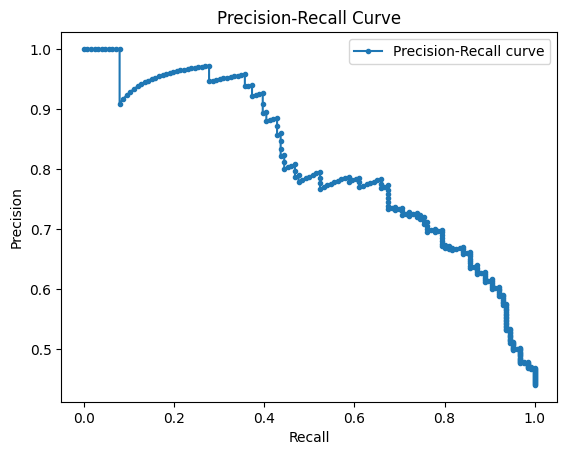

In [ ]:
y_pred_probs = baseline.predict(x_test)
y_pred_probs = y_pred_probs.ravel()

# Calculate precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_probs)

# Plot the Precision-Recall curve
plt.figure()
plt.plot(recall, precision, marker='.', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

plotting confusion matrix

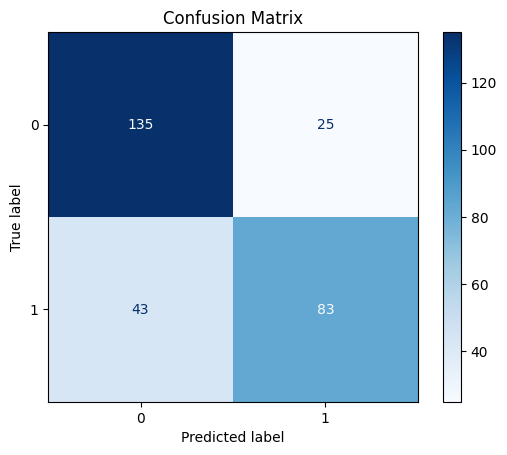

In [ ]:
# Convert probabilities to binary class predictions
y_pred_classes = (y_pred_probs > 0.5).astype(int)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Display confusion matrix using sklearn's visualization tool
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

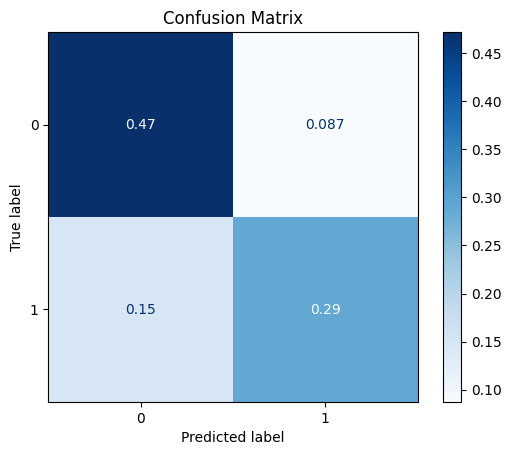

In [ ]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_classes, normalize='all')

# Display confusion matrix using sklearn's visualization tool
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
#check whether train and test sets are imbalanced
print(f"positive classes in test set: {(y_test == 1).sum()}; negative class in test set: {(y_test == 0).sum()}")
print(f"positive classes in test set: {(y_train == 1).sum()}; negative class in test set: {(y_train == 0).sum()}")

positive classes in test set: 126; negative class in test set: 160
positive classes in test set: 1137; negative class in test set: 1733


In [ ]:
#Let's see example of errors

# False Positive: Predicted as 1 but actual is 0
false_positives = np.where((y_pred_classes == 1) & (y_test.astype('int32') == 0))[0]

# False Negative: Predicted as 0 but actual is 1
false_negatives = np.where((y_pred_classes == 0) & (y_test.astype('int32') == 1))[0]

In [ ]:
#detokenizing the sequences
def detokenize(sequence, index_to_word):

    # 4. Map tokens to indices, use 'UNK' index if not found
    text = [index_to_word.get(token, '') for token in sequence]

    return ' '.join(text)

In [ ]:
#Let's see all False Negatives and count how many of them contain OOV
oov = 0

for id in false_negatives:
    detokenized = detokenize(x_test[id][x_test[id]>0], idx_to_word)
    print(f"detokenized lemmatized version of tweet: {detokenized}")
    print(f"real tweet: {test['tweet'].iloc[id]}")
    print(f"{detokenized.count('UNK')} OOV tokens")
    print()
    if 'UNK' in detokenized:
      oov += 1

print(f"Number of False Negatives with OOV word is: {oov} out of {len(false_negatives)}")

detokenized lemmatized version of tweet: UNK get gangbanged to death
real tweet: suika gets gangbanged to death
1 OOV tokens

detokenized lemmatized version of tweet: maybe something involve her get gangbanged
real tweet: maybe something involving her getting gangbanged
0 OOV tokens

detokenized lemmatized version of tweet: UNK islamic UNK of afghanistan have announce the end of UNK in the country cite gender UNK student will attend university on UNK wednesday and saturday while tuesday thursday and sunday be fix for male
real tweet: kabul islamic emirate of afghanistan has announced the end of coeducation in the country citing gender harassmentfemale students will attend universities on monday wednesday and saturday while tuesday thursday and sunday are fixed for males
5 OOV tokens

detokenized lemmatized version of tweet: the violent UNK of a farright movement that see UNK a vessel for breed a new white generation express itself in a UNK on UNK to traditional gender UNK every minute 

In [ ]:
#looking at the worst False Negatives
worst_FN = np.where(y_pred_probs[false_negatives] <= 0.1)[0]

for id in worst_FN:
    detokenized = detokenize(x_test[false_negatives[id]][x_test[false_negatives[id]]>0], idx_to_word)
    print(y_pred_probs[false_negatives[id]])
    print(f"detokenized lemmatized version of tweet: {detokenized}")
    print(f"real tweet: {test['tweet'].iloc[false_negatives[id]]}")
    print(f"{detokenized.count('UNK')} OOV tokens")
    print()

0.027638953
detokenized lemmatized version of tweet: the violent UNK of a farright movement that see UNK a vessel for breed a new white generation express itself in a UNK on UNK to traditional gender UNK every minute to read take 5 min out of your sun
real tweet: the violent antifeminism of a farright movement that sees principally as vessels for breeding a new white generation expresses itself in a fixation on areturn to traditional gender rolesworth every minute to read take 5 min out of your sun
5 OOV tokens

0.008614599
detokenized lemmatized version of tweet: that gold digger be nice but the picture and set up for them be elite UNK be like the UNK of the UNK UNK always a work of art
real tweet: that gold digger is nice but the picture and set up for them are elite pinwork is like the revealing of the mona lisa always a work of art
4 OOV tokens

0.09381234
detokenized lemmatized version of tweet: go weak rn play the UNK manspreading i be on my knee
real tweet: going weak rn playing

In [ ]:
#Let's see all False Positives and count how many of them contain OOV
oov = 0

for id in false_positives:
    detokenized = detokenize(x_test[id][x_test[id]>0], idx_to_word)
    print(f"detokenized lemmatized version of tweet: {detokenized}")
    print(f"real tweet: {test['tweet'].iloc[id]}")
    print(f"{detokenized.count('UNK')} OOV tokens")
    print()
    if 'UNK' in detokenized:
      oov += 1

print(f"Number of False Positives with OOV word is: {oov} out of {len(false_positives)}")

detokenized lemmatized version of tweet: sex a in gender harassment be what they be UNK
real tweet: sex as in gender harassment is what they are inferring
1 OOV tokens

detokenized lemmatized version of tweet: my baby call me UNK sha for the first time today twice yall dont understand how UNK that make me baby girl have autism and get her to talk without be prompt have be a challenge shes come so far
real tweet: my baby called me mommy sha for the first time today twice yall dont understand how hype that made me baby girl has autism and getting her to talk without being prompted has been a challenge shes come so far
2 OOV tokens

detokenized lemmatized version of tweet: how do we reach a point where UNK be have the UNK to talk about UNK rap do yall see who you stan be yall ok your girl cant write cant deliver cant come close to UNK UNK tf be yall get brave for fashion deal
real tweet: how did we reach a point where blonks are having the audacity to talk about yoongis rap do yall see wh

In [ ]:
#worst False Positives
worst_FP = np.where(y_pred_probs[false_positives] >= 0.9)[0]

for id in worst_FP:
    detokenized = detokenize(x_test[false_positives[id]][x_test[false_positives[id]]>0], idx_to_word)
    print(y_pred_probs[false_positives[id]])
    print(f"detokenized lemmatized version of tweet: {detokenized}")
    print(f"real tweet: {test['tweet'].iloc[false_positives[id]]}")
    print(f"{detokenized.count('UNK')} OOV tokens")
    print()

0.989393
detokenized lemmatized version of tweet: yup i hate when men rape and kill woman
real tweet: yup i hate when men rape and kill women
0 OOV tokens

0.9421292
detokenized lemmatized version of tweet: not all men look good with beard btw pls stop try to grow it out
real tweet: not all men look good with beard btw pls stop trying to grow it out
0 OOV tokens

0.90187263
detokenized lemmatized version of tweet: my new favorite meme be the pregnant woman drive in the UNK UNK lane tell the state trooper who pull her over that she be drive with another person
real tweet: my new favorite meme is the pregnant woman driving in the oklahoma hov lane telling the state trooper who pulled her over that she is driving with another person
2 OOV tokens



#### Error analysis for transformer model

In [ ]:
#load the model
model_directory = "/content/drive/MyDrive/assignment-2425/transformer/results/checkpoint-359"

tokenizer = AutoTokenizer.from_pretrained(model_directory)
model = AutoModelForSequenceClassification.from_pretrained(model_directory, num_labels=2)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
print()

In [ ]:
train_texts = training['lemmatized'].tolist()
val_texts = validation['lemmatized'].tolist()
test_texts = test['lemmatized'].tolist()

train_labels = training['hard_label_task1'].tolist()
val_labels = validation['hard_label_task1'].tolist()
test_labels = test['hard_label_task1'].tolist()

In [ ]:
# Tokenize the training and testing data
train_encodings = tokenizer(train_texts)
val_encodings = tokenizer(val_texts)
test_encodings = tokenizer(test_texts)

In [ ]:
class SexismDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = SexismDataset(train_encodings, train_labels)
val_dataset = SexismDataset(val_encodings, val_labels)
test_dataset = SexismDataset(test_encodings, test_labels)

In [ ]:
def predict_sexism(texts, tokenizer, model, device, threshold=0.5):
    """
    Predicts whether each text in `texts` contains sexism.

    Args:
        texts (list of str): The input texts to classify.
        tokenizer (transformers.PreTrainedTokenizer): The tokenizer.
        model (transformers.PreTrainedModel): The classification model.
        device (torch.device): The device to run the model on.
        threshold (float): Threshold for classification (optional).

    Returns:
        list of int: Predictions (0 or 1) for each text.
        list of float: Probability scores for the positive class.
    """
    # Tokenize the input texts
    encodings = tokenizer(
        texts,
        truncation=True,
        padding=True,
        return_tensors="pt"
    )

    # Move tensors to the appropriate device
    input_ids = encodings['input_ids'].to(device)
    attention_mask = encodings['attention_mask'].to(device)

    # Perform inference without gradient computation
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

    # Apply softmax to get probabilities
    probabilities = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()  # Probability for class 1

    # Apply threshold to get binary predictions
    predictions = (probabilities >= threshold).astype(int)

    return predictions.tolist(), probabilities.tolist()

In [ ]:
# getting the predictions
tweets = test['lemmatized'].values.tolist()

predictions, probabilities = predict_sexism(tweets, tokenizer, model, device)

In [ ]:
print(f1_score(test_labels, predictions, average='macro'))

0.7761799951088286


Plotting precision-recall curve

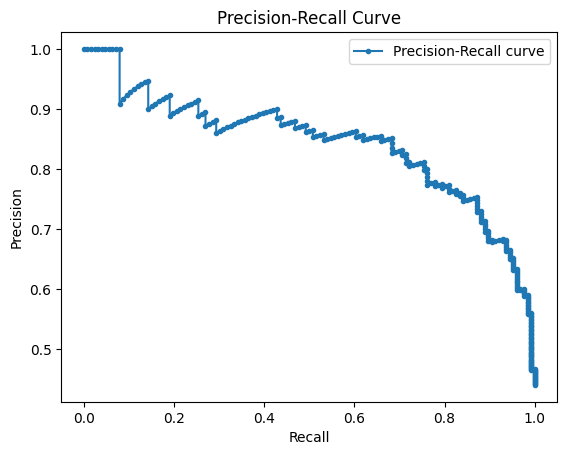

In [ ]:
# Calculate precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(test_labels, probabilities)

# Plot the Precision-Recall curve
plt.figure()
plt.plot(recall, precision, marker='.', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

plotting confusion matrices

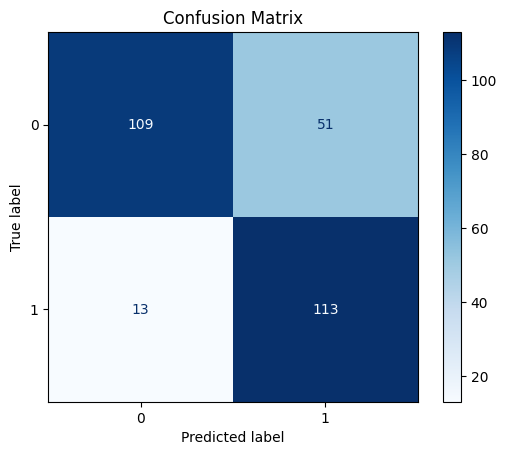

In [ ]:
cm = confusion_matrix(test_labels, predictions)

# Display confusion matrix using sklearn's visualization tool
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

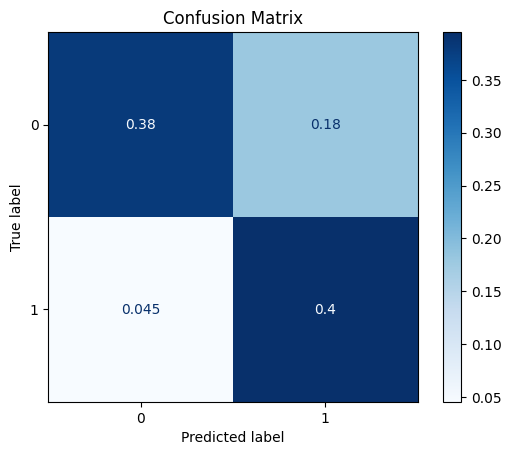

In [ ]:
cm = confusion_matrix(test_labels, predictions, normalize='all')

# Display confusion matrix using sklearn's visualization tool
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
#Let's see example of errors

# False Positive: Predicted as 1 but actual is 0
false_positives = np.where((np.asarray(predictions) == 1) & (np.asarray(test_labels) == 0))[0]

# False Negative: Predicted as 0 but actual is 1
false_negatives = np.where((np.asarray(predictions) == 0) & (np.asarray(test_labels) == 1))[0]

In [ ]:
#Let's see all False Negatives

for id in false_negatives:
    detokenized = tokenizer.decode(test_encodings['input_ids'][id])
    print(f"detokenized version of tweet: {detokenized}")
    print(f"real tweet: {test['tweet'].iloc[id]}")
    print(f"confidence: {probabilities[id]}")
    print()

detokenized version of tweet: <s>the violent antifeminism of a farright movement that see principally a vessel for breed a new white generation express itself in a fixation on areturn to traditional gender rolesworth every minute to read take 5 min out of your sun</s>
real tweet: the violent antifeminism of a farright movement that sees principally as vessels for breeding a new white generation expresses itself in a fixation on areturn to traditional gender rolesworth every minute to read take 5 min out of your sun
confidence: 0.4322090148925781

detokenized version of tweet: <s>that gold digger be nice but the picture and set up for them be elite pinwork be like the revealing of the mona lisa always a work of art</s>
real tweet: that gold digger is nice but the picture and set up for them are elite pinwork is like the revealing of the mona lisa always a work of art
confidence: 0.16468659043312073

detokenized version of tweet: <s>call to clean up parliament laddish culture after mp po

In [ ]:
#Let's see all False Positives

for id in false_positives:
    detokenized = tokenizer.decode(test_encodings['input_ids'][id])
    print(f"detokenized version of tweet: {detokenized}")
    print(f"real tweet: {test['tweet'].iloc[id]}")
    print(f"confidence: {probabilities[id]}")
    print()


detokenized version of tweet: <s>i mean i do but wouldnt it be fun to get gangbanged together</s>
real tweet: i mean i do but wouldnt it be fun to get gangbanged together
confidence: 0.7706142067909241

detokenized version of tweet: <s>sex a in gender harassment be what they be infer</s>
real tweet: sex as in gender harassment is what they are inferring
confidence: 0.7141639590263367

detokenized version of tweet: <s>appreciate be include along with on the uvalde gunman history of cyber gender harassment regrettably unshocking</s>
real tweet: appreciate being included along with on the uvalde gunmans history of cyber gender harassment regrettably unshocking
confidence: 0.6211192607879639

detokenized version of tweet: <s>isa hot girl summer now pop yall shit</s>
real tweet: isa hot girl summer now pop yall shit
confidence: 0.7891538739204407

detokenized version of tweet: <s>my baby call me mommy sha for the first time today twice yall dont understand how hype that make me baby girl ha

# [Task 8 - 0.5 points] Report

Wrap up your experiment in a short report (up to 2 pages).

### Instructions

* Use the NLP course report template.
* Summarize each task in the report following the provided template.

### Recommendations

The report is not a copy-paste of graphs, tables, and command outputs.

* Summarize classification performance in Table format.
* **Do not** report command outputs or screenshots.
* Report learning curves in Figure format.
* The error analysis section should summarize your findings.


# Submission

* **Submit** your report in PDF format.
* **Submit** your python notebook.
* Make sure your notebook is **well organized**, with no temporary code, commented sections, tests, etc...
* You can upload **model weights** in a cloud repository and report the link in the report.

# FAQ

Please check this frequently asked questions before contacting us

### Execution Order

You are **free** to address tasks in any order (if multiple orderings are available).

### Trainable Embeddings

You are **free** to define a trainable or non-trainable Embedding layer to load the GloVe embeddings.

### Model architecture

You **should not** change the architecture of a model (i.e., its layers).
However, you are **free** to play with their hyper-parameters.


### Neural Libraries

You are **free** to use any library of your choice to implement the networks (e.g., Keras, Tensorflow, PyTorch, JAX, etc...)

### Keras TimeDistributed Dense layer

If you are using Keras, we recommend wrapping the final Dense layer with `TimeDistributed`.

### Robust Evaluation

Each model is trained with at least 3 random seeds.

Task 4 requires you to compute the average performance over the 3 seeds and its corresponding standard deviation.

### Model Selection for Analysis

To carry out the error analysis you are **free** to either

* Pick examples or perform comparisons with an individual seed run model (e.g., Baseline seed 1337)
* Perform ensembling via, for instance, majority voting to obtain a single model.

### Error Analysis

Some topics for discussion include:
   * Precision/Recall curves.
   * Confusion matrices.
   * Specific misclassified samples.

### Bonus Points
Bonus points are arbitrarily assigned based on significant contributions such as:
- Outstanding error analysis
- Masterclass code organization
- Suitable extensions
Note that bonus points are only assigned if all task points are attributed (i.e., 6/6).

**Possible Extensions/Explorations for Bonus Points:**
- **Try other preprocessing strategies**: e.g., but not limited to, explore techniques tailored specifically for tweets or  methods that are common in social media text.
- **Experiment with other custom architectures or models from HuggingFace**
- **Explore Spanish tweets**: e.g., but not limited to, leverage multilingual models to process Spanish tweets and assess their performance compared to monolingual models.







# The End